## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import measure
from skimage.measure import regionprops, regionprops_table
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import load_img
from importlib import reload
import segmenteverygrain as seg
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from tqdm import trange
%matplotlib qt

## Load models

In [2]:
model = seg.Unet()
model.compile(optimizer=Adam(), loss=seg.weighted_crossentropy, metrics=["accuracy"])
# you need to download the 'segmenteverygrain' model for this to work ()
model.load_weights('./checkpoints/seg_model');

# the SAM model checkpoints can be downloaded from: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
sam = sam_model_registry["default"](checkpoint="/Users/zoltan/Dropbox/Segmentation/sam_vit_h_4b8939.pth")

2024-03-28 11:40:06.554885: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-28 11:40:06.555069: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Max


## Run segmentation

Grains are supposed to be well defined in the image; e.g., if a grain consists of only a few pixels, it is unlikely to be detected.

The segmentation can take a few minutes even for medium-sized images, so do not start with large images (downsample them if necessary). Images with ~2000 pixels along their largest dimension are a good start.

In [3]:
fname = '/Users/zoltan/Dropbox/Segmentation/Kalinda_Roberts_project/RI_T01_Grid_65.tif'

big_im = np.array(load_img(fname))
big_im_pred = seg.predict_big_image(big_im, model, I=256)
# decreasing the 'dbs_max_dist' parameter results in more SAM prompts (and longer processing times):
labels, grains, coords = seg.label_grains(big_im, big_im_pred, dbs_max_dist=10.0)
all_grains, labels, mask_all, grain_data, fig, ax = seg.sam_segmentation(sam, big_im, big_im_pred, coords, labels, min_area=50.0)

  0%|                                                     | 0/6 [00:00<?, ?it/s]2024-03-28 11:40:34.513163: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-28 11:40:34.586556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
100%|███████████████████████████████████████| 1346/1346 [01:17<00:00, 17.41it/s]
1321it [01:24, 15.71it/s]
100%|████████████████████████████████████████| 441/441 [00:01<00:00, 279.65it/s]


## Delete or merge grains in segmentation result
* click on the grain that you want to remove and press the 'x' key
* click on two grains that you want to merge and press the 'm' key (they have to be the last two grains you clicked on)
* press the 'g' key to hide the grain masks (so that you can see the original image better); press the 'g' key again to show the grain masks

In [45]:
grain_inds = []
cid1 = fig.canvas.mpl_connect('button_press_event', 
                              lambda event: seg.onclick2(event, all_grains, grain_inds, ax=ax))
cid2 = fig.canvas.mpl_connect('key_press_event', 
                              lambda event: seg.onpress2(event, all_grains, grain_inds, fig=fig, ax=ax))

Run this cell if you do not want to delete / merge existing grains anymore; it is a good idea to do this before moving on to the next step.

In [46]:
fig.canvas.mpl_disconnect(cid1)
fig.canvas.mpl_disconnect(cid2)

Use this function to update the 'all_grains' list after deleting and merging grains:

In [47]:
all_grains, labels, mask_all, fig, ax = seg.get_grains_from_patches(ax, big_im)

100%|████████████████████████████████████████| 320/320 [00:02<00:00, 120.91it/s]


Plot the updated set of grains:

In [51]:
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(big_im)
plt.xticks([])
plt.yticks([])
seg.plot_image_w_colorful_grains(big_im, all_grains, ax, cmap='Paired')
seg.plot_grain_axes_and_centroids(all_grains, labels, ax, linewidth=1, markersize=10)
plt.xlim([0, np.shape(big_im)[1]])
plt.ylim([np.shape(big_im)[0], 0]);

## Add new grains using the Segment Anything Model

* click on unsegmented grain that you want to add
* press the 'x' key if you want to delete the last grain you added
* press the 'm' key if you want to merge the last two grains that you added
* right click outside the grain (but inside the most recent mask) if you want to restrict the grain to a smaller mask - this adds a background prompt

In [49]:
predictor = SamPredictor(sam)
predictor.set_image(big_im) # this can take a while
coords = []
cid3 = fig.canvas.mpl_connect('button_press_event', lambda event: seg.onclick(event, ax, coords, big_im, predictor))
cid4 = fig.canvas.mpl_connect('key_press_event', lambda event: seg.onpress(event, ax, fig))

In [64]:
fig.canvas.mpl_disconnect(cid3)
fig.canvas.mpl_disconnect(cid4)

After you are done with the deletion / addition of grain masks, run this cell to generate an updated set of grains:

In [50]:
all_grains, labels, mask_all, fig, ax = seg.get_grains_from_patches(ax, big_im)

100%|████████████████████████████████████████| 354/354 [00:02<00:00, 124.70it/s]


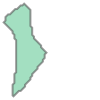

In [26]:
all_grains[10]

## Get grain size distribution

Run this cell and then click (left mouse button) on one end of the scale bar in the image and click (right mouse button) on the other end of the scale bar:

In [52]:
cid5 = fig.canvas.mpl_connect('button_press_event', lambda event: seg.click_for_scale(event, ax))

number of pixels: 193.11


Use the length of the scale bar in pixels (it should be printed above) to get the scale of the image (in units / pixel):

In [57]:
n_of_units = 500 # centimeters in the case of 'IMG_5208_image.png'
units_per_pixel = n_of_units/193.11 # length of scale bar in pixels

In [58]:
props = regionprops_table(labels.astype('int'), intensity_image = big_im, properties =\
        ('label', 'area', 'centroid', 'major_axis_length', 'minor_axis_length', 
         'orientation', 'perimeter', 'max_intensity', 'mean_intensity', 'min_intensity'))
grain_data = pd.DataFrame(props)
grain_data['major_axis_length'] = grain_data['major_axis_length'].values*units_per_pixel
grain_data['minor_axis_length'] = grain_data['minor_axis_length'].values*units_per_pixel
grain_data['perimeter'] = grain_data['perimeter'].values*units_per_pixel
grain_data['area'] = grain_data['area'].values*units_per_pixel**2

In [59]:
grain_data.head()

,label,area,centroid-0,centroid-1,major_axis_length,minor_axis_length,orientation,perimeter,max_intensity-0,max_intensity-1,max_intensity-2,mean_intensity-0,mean_intensity-1,mean_intensity-2,min_intensity-0,min_intensity-1,min_intensity-2
0,1,15016.838126,20.546875,945.926786,168.641397,118.488355,1.139348,483.430889,255.0,255.0,255.0,218.377232,212.426339,219.841071,60.0,43.0,13.0
1,2,10176.589408,339.316206,1820.215415,144.012838,92.730107,-1.510110,397.175106,255.0,255.0,255.0,183.735178,177.980237,181.127141,27.0,47.0,38.0
2,3,17182.212552,451.810769,15.046430,231.092918,99.993859,-0.021373,573.868806,238.0,233.0,255.0,205.172844,203.001171,209.460008,62.0,64.0,54.0
3,4,11812.352133,514.209989,629.208286,149.117158,102.839337,0.292422,422.546630,255.0,255.0,255.0,219.042565,214.907491,220.919410,40.0,77.0,66.0
4,5,10712.905056,551.856696,465.237797,177.367748,78.752628,-1.112341,441.483269,255.0,249.0,255.0,204.268461,198.521902,202.667710,53.0,68.0,58.0


In [60]:
plt.figure()
plt.hist(grain_data['major_axis_length'], 25)
plt.xlabel('major axis length (microns)')
plt.ylabel('count');

## Save mask and image to PNG files

In [486]:
dirname = '/Users/zoltan/Dropbox/Segmentation/images/'
# write grayscale mask to PNG file
cv2.imwrite(dirname + fname.split('/')[-1][:-4] + '_mask.png', mask_all)
# Save the image as a PNG file
cv2.imwrite(dirname + fname.split('/')[-1][:-4] + '_image.png', cv2.cvtColor(big_im, cv2.COLOR_BGR2RGB))

True

## Convert polygon row, col coordinates to projected coordinates and save them to shapefile

In [4]:
import rasterio
dataset = rasterio.open(fname)

In [5]:
dataset.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 1113,
 'height': 1112,
 'count': 4,
 'crs': CRS.from_epsg(32619),
 'transform': Affine(0.0017999999999882017, 0.0, 339041.9403932594,
        0.0, -0.0018000000000683416, 4686358.8424565075)}

In [6]:
# convert polygon coordinates from row, col to UTM
from shapely.geometry import Polygon
projected_polys = []
for grain in all_grains:
    x, y = rasterio.transform.xy(dataset.transform, grain.exterior.xy[1], grain.exterior.xy[0])
    poly = Polygon(np.vstack((x, y)).T)
    projected_polys.append(poly)

In [7]:
# create geopandas dataframe
import geopandas
gdf = geopandas.GeoDataFrame(projected_polys, columns = ['geometry'])
gdf.head()

,geometry
0,"POLYGON ((339043.428 4686358.675, 339043.426 4..."
1,"POLYGON ((339042.953 4686357.667, 339042.951 4..."
2,"POLYGON ((339042.181 4686357.410, 339042.179 4..."
3,"POLYGON ((339042.022 4686357.336, 339042.020 4..."
4,"POLYGON ((339043.865 4686357.228, 339043.864 4..."


In [8]:
# create property dataframe from labeled image
props = regionprops_table(labels.astype('int'), intensity_image = big_im, properties =\
        ('label', 'area', 'centroid', 'major_axis_length', 'minor_axis_length'))
grain_data = pd.DataFrame(props)
grain_data['major_axis_length'] = grain_data['major_axis_length'].values
grain_data['minor_axis_length'] = grain_data['minor_axis_length'].values
grain_data['area'] = grain_data['area'].values
grain_data.head()

,label,area,centroid-0,centroid-1,major_axis_length,minor_axis_length
0,1,371,78.140162,826.512129,26.579295,18.273030
1,2,987,633.116515,552.331307,45.044539,29.214000
2,3,198,786.873737,131.095960,18.471024,13.888250
3,4,420,821.252381,41.250000,30.301088,18.403316
4,5,812,880.109606,1069.188424,38.886262,27.357959


In [9]:
# convert centroids from row, col to UTM and add them to geodataframe
centroid_x, centroid_y = rasterio.transform.xy(dataset.transform, grain_data['centroid-0'], 
                                               grain_data['centroid-1'])
gdf['centroid_x'] = centroid_x
gdf['centroid_y'] = centroid_y

In [10]:
# convert grain axis lengths to UTM units
gdf['major_axis_length'] = grain_data['major_axis_length'] * dataset.transform[0]
gdf['minor_axis_length'] = grain_data['minor_axis_length'] * dataset.transform[0]
gdf.head()

,geometry,centroid_x,centroid_y,major_axis_length,minor_axis_length
0,"POLYGON ((339043.428 4686358.675, 339043.426 4...",339043.429015,4.686359e+06,0.047843,0.032891
1,"POLYGON ((339042.953 4686357.667, 339042.951 4...",339042.935490,4.686358e+06,0.081080,0.052585
2,"POLYGON ((339042.181 4686357.410, 339042.179 4...",339042.177266,4.686357e+06,0.033248,0.024999
3,"POLYGON ((339042.022 4686357.336, 339042.020 4...",339042.015543,4.686357e+06,0.054542,0.033126
4,"POLYGON ((339043.865 4686357.228, 339043.864 4...",339043.865832,4.686357e+06,0.069995,0.049244


In [15]:
# check if everything looks good
band1 = dataset.read(1)
band2 = dataset.read(2)
band3 = dataset.read(3)
plt.figure()
plt.imshow(np.stack((band1, band2, band3), axis=2), extent = [dataset.bounds[0], dataset.bounds[2], 
                                         dataset.bounds[1], dataset.bounds[3]])
plt.scatter(gdf['centroid_x'], gdf['centroid_y']);

In [14]:
gdf.crs = dataset.crs # set geodataframe CRS

In [16]:
gdf.to_file("/Users/zoltan/Dropbox/Segmentation/Kalinda_Roberts_project/projected_grains.shp") # write shapefile

/var/folders/5h/h0hb76hj7h90xczzdv1425fr0000gp/T/ipykernel_73938/571464815.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("/Users/zoltan/Dropbox/Segmentation/Kalinda_Roberts_project/projected_grains.shp") # write shapefile


In [17]:
dataset.close()